## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

# Contents
1. Redistribute Data
2. Visualizations of before and after
3. Show image sizes data
4. Create Dataset
5. Display images after resizing
6. Process data
7. Display images after processing

In [ ]:
%load_ext autoreload
%autoreload 2

## 1. Redistribute Data

In [8]:
import os
import shutil
import sys
from sklearn.model_selection import train_test_split

def create_directory_structure(base_path, dir_names, labels):
    directories = {}
    for dir_name in dir_names:
        dir_path = os.path.join(base_path, dir_name)
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        for label in labels:
            label_dir = os.path.join(dir_path, label)
            if not os.path.exists(label_dir):
                os.makedirs(label_dir)
        directories[dir_name] = dir_path
    return directories

def collect_and_combine_data(source_dirs, dest_dir,labels):
    for label in labels:
        files = []
        for dir_path in source_dirs:
            label_dir = os.path.join(dir_path, label)
            files.extend([os.path.join(label_dir, f) for f in os.listdir(label_dir) if os.path.isfile(os.path.join(label_dir, f))])
        
        combined_dir = os.path.join(dest_dir, label)
        for file in files:
            try:
                shutil.copy(file, combined_dir)
            except IOError as e:
                print(f"Unable to copy file. {e}")
            except:
                print("Unexpected error:", sys.exc_info())

def split_and_distribute_data(source_dir, target_dirs, labels, split_ratio=(0.8, 0.1, 0.1)):
    for label in labels:
        files = [os.path.join(source_dir, label, f) for f in os.listdir(os.path.join(source_dir, label)) if os.path.isfile(os.path.join(source_dir, label, f))]
        
        train_files, test_files = train_test_split(files, test_size=split_ratio[1] + split_ratio[2], random_state=42)
        val_files, test_files = train_test_split(test_files, test_size=split_ratio[2] / (split_ratio[1] + split_ratio[2]), random_state=42)
        
        for files, dir_name in zip([train_files, val_files, test_files], ['new_train', 'new_val', 'new_test']):
            copy_files(files, target_dirs[dir_name], label)
    
    # delete temporary directory
    shutil.rmtree(source_dir)

def copy_files(files, dest_dir, label):
    for file in files:
        try:
            shutil.copy(file, os.path.join(dest_dir, label))
        except IOError as e:
            print(f"Unable to copy file. {e}")
        except:
            print("Unexpected error:", sys.exc_info())


In [9]:
# Base directory
base_dir = "data/chest_xray"

# Labels
labels = ["NORMAL", "PNEUMONIA"]

new_dir_names = ['new_train', 'new_val', 'new_test', 'temp_combined']

# Initialize directories
new_dirs = create_directory_structure(base_dir, new_dir_names, labels)

# Original directories
original_dirs = [os.path.join(base_dir, name) for name in ['train', 'test', 'val']]

# Collect and combine data into a temporary directory
collect_and_combine_data(original_dirs, new_dirs['temp_combined'], labels)

# Split and distribute data
split_and_distribute_data(new_dirs['temp_combined'], new_dirs, labels, split_ratio=(0.8, 0.1, 0.1))

## 2. Visualizations of before and after

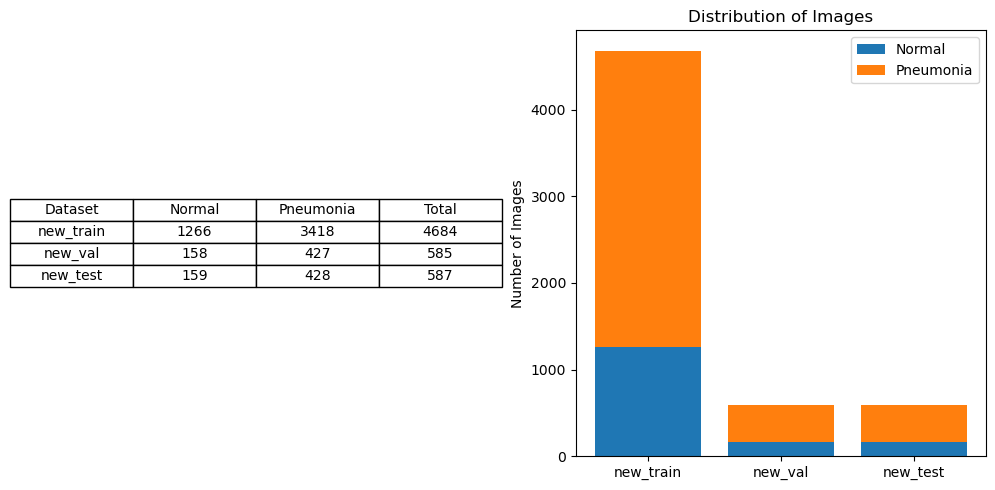

In [12]:
from code.distribution_viz import prepare_plot, bars_data
data_dir = "data/chest_xray"
folders = ['new_train', 'new_val', 'new_test']
new_df = prepare_plot(data_dir,folders)
bars_data(new_df)

In [18]:

# Collecting pre and post dataold_folders = ['train', 'val', 'test']
old_df = prepare_plot(data_dir,old_folders)
old_df

,Dataset,Normal,Pneumonia,Total
0,train,1341,3875,5216
1,val,8,8,16
2,test,234,390,624


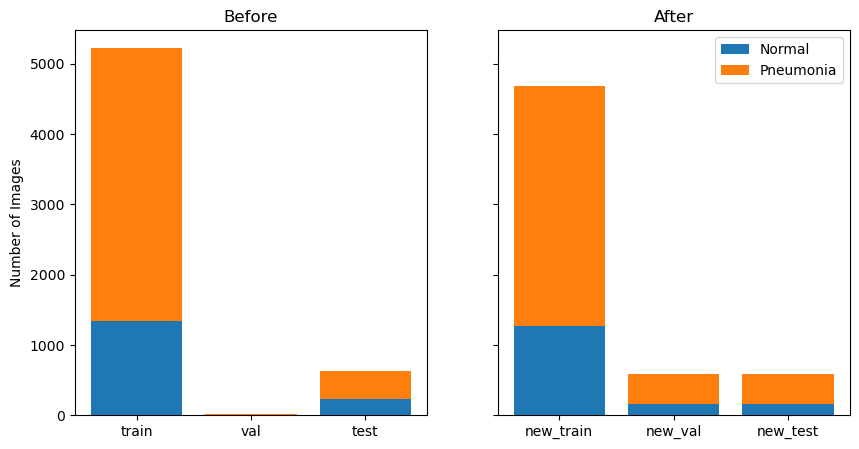

In [19]:
import matplotlib.pyplot as plt
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax[0].bar(old_df['Dataset'], old_df['Normal'], label='Normal')
ax[0].bar(old_df['Dataset'], old_df['Pneumonia'], bottom=old_df['Normal'], label='Pneumonia')
ax[0].set_ylabel('Number of Images')
ax[0].set_title('Before')
ax[1].bar(new_df['Dataset'], new_df['Normal'], label='Normal')
ax[1].bar(new_df['Dataset'], new_df['Pneumonia'], bottom=new_df['Normal'], label='Pneumonia')
ax[1].set_title('After')
plt.legend()

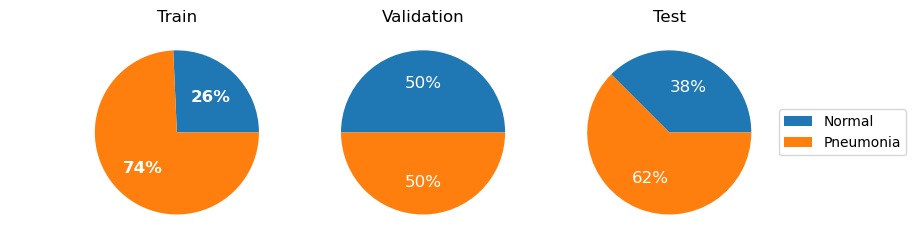

In [22]:
def pies(df):
    df['norm_rate']=round((df['Normal']/df['Total'])*100,2)
    df['pneu_rate']=round((df['Pneumonia']/df['Total'])*100,2)
    fig, ax = plt.subplots(1,3, figsize=(9,3))
    ax[0].pie(list(df.iloc[0,4:6]), labels=['Normal','Pneumonia'], autopct='%1.f%%', textprops={'fontsize': 12, 'color': 'white', 'fontweight':'bold'})
    ax[0].set_title('Train')
    ax[1].pie(list(df.iloc[1,4:6]), labels=['Normal','Pneumonia'], autopct='%1.f%%', textprops={'fontsize': 12, 'color': 'white'})
    ax[1].set_title('Validation')
    ax[2].pie(list(df.iloc[2,4:6]), labels=['Normal','Pneumonia'], autopct='%1.f%%', textprops={'fontsize': 12, 'color': 'white'})
    ax[2].set_title('Test')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
pies(old_df)

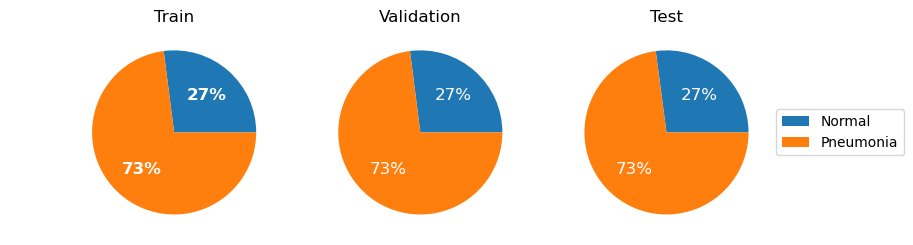

In [23]:
pies(new_df)

Text(0.5, 1.0, 'After')

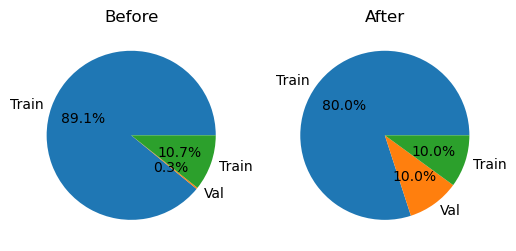

In [25]:
old_df['total_rate']= round((old_df['Total']/old_df['Total'].sum())*100,2)
new_df['total_rate']= round((new_df['Total']/new_df['Total'].sum())*100,2)
list(old_df['total_rate'])

fig, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].pie(list(old_df['total_rate']), labels=['Train','Val', 'Train'], autopct='%1.1f%%')
ax[0].set_title('Before')
ax[1].pie(list(new_df['total_rate']), labels=['Train','Val', 'Train'], autopct='%1.1f%%')
ax[1].set_title('After')

## 3. Show image sizes data

In [31]:
from PIL import Image
import os
import numpy as np

def get_image_sizes(directory):
    """Collect widths and heights of images with given extensions in directory."""
    sizes = [(img.size) for root, dirs, files in os.walk(directory)
             for file in files if file.lower().endswith('jpeg')
             for img in (Image.open(os.path.join(root, file)),)]
    return zip(*sizes)  # Unzips the sizes into two lists: widths and heights

def print_image_statistics(widths, heights):
    """Print statistics for a collection of image widths and heights."""
    num_images = len(widths)
    avg_width = round(np.mean(widths))
    avg_height = round(np.mean(heights))
    avg_aspect_ratio = np.mean(widths) / np.mean(heights)
    max_width = max(widths)
    max_height = max(heights)
    min_width = min(widths)
    min_height = min(heights)
    
    print(f"Number of images: {num_images}")
    print(f"Average width: {avg_width}")
    print(f"Average height: {avg_height}")
    print(f"Average aspect ratio: {avg_aspect_ratio:.2f}")
    print(f"Max width: {max_width}")
    print(f"Max height: {max_height}")
    print(f"Min width: {min_width}")
    print(f"Min height: {min_height}")
    return avg_aspect_ratio

In [33]:
train_dir = 'data/chest_xray/new_train/'
test_dir = 'data/chest_xray/new_test/'

train_widths, train_heights = get_image_sizes(train_dir)
test_widths, test_heights = get_image_sizes(test_dir)

widths = np.concatenate((train_widths, test_widths))
heights = np.concatenate((train_heights, test_heights))

avg_ratio = print_image_statistics(widths, heights)

Number of images: 5271
Average width: 1330
Average height: 972
Average aspect ratio: 1.37
Max width: 2890
Max height: 2713
Min width: 384
Min height: 127


## 4. Create Dataset

In [74]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
tf.random.set_seed(42)
import warnings
warnings.filterwarnings('ignore')

def create_dataset(directory, width, batch_size, ratio = avg_ratio):
    height = int(width/ratio)
    dataset = image_dataset_from_directory(directory,
                                        label_mode='binary',
                                        color_mode="grayscale", # will save memory as images are already in grayscale
                                        batch_size=batch_size,
                                        image_size=(height,width),
                                        shuffle=True,
                                        crop_to_aspect_ratio = True,
                                        seed=42)
    return dataset

# possible width sizes
# 1024, 512, 256, 128, 64, 32

In [75]:
# from code.data_loader import create_dataset
train_dir = "data/chest_xray/new_train"
val_dir = "data/chest_xray/new_val"
test_dir = "data/chest_xray/new_test"


train_ds = create_dataset(train_dir,ratio = avg_ratio, width_size=256, batch=32)
val_ds = create_dataset(val_dir,ratio = avg_ratio, width_size=256, batch=32)
test_ds = create_dataset(test_dir,ratio = avg_ratio, width_size=256, batch=32)

Found 4684 files belonging to 2 classes.
Found 585 files belonging to 2 classes.
Found 587 files belonging to 2 classes.


## 5. Display images after resizing

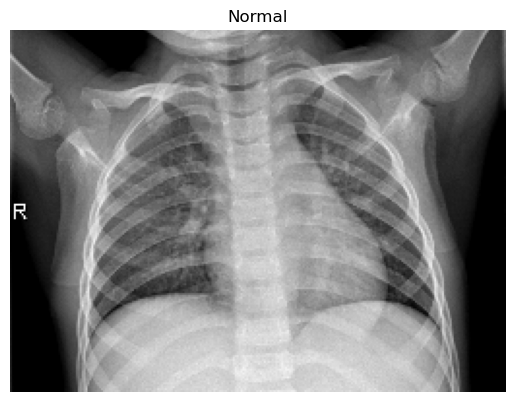

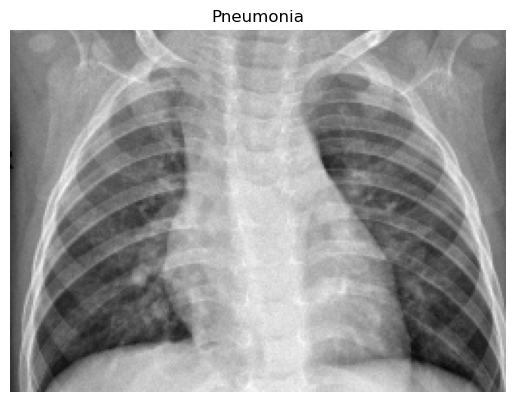

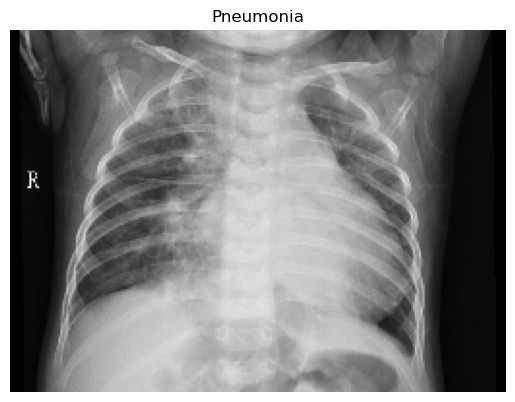

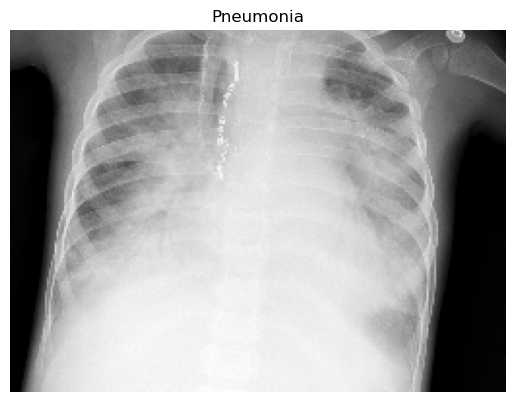

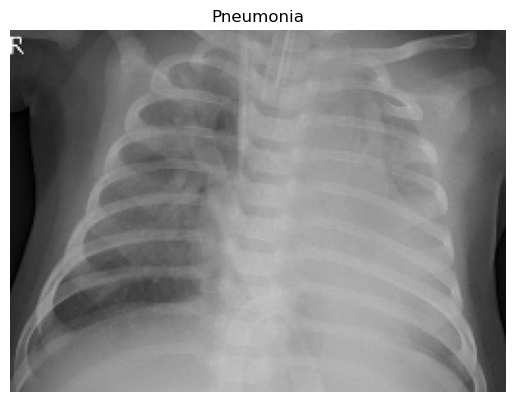

In [66]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Take the first batch from the dataset
for images, labels in train_ds.take(5):
    # Select the first image and label from the batch
    image = images[0]
    label = labels[0]
    if label == 0:
        label = 'Normal'
    else:
        label = 'Pneumonia'
    
    fig, ax = plt.subplots()
    ax.axis('off')
    ax.imshow(image,cmap='gray')
    ax.set_title(label)
    plt.show()


## 6. Process data

In [79]:
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
def process_dataset(dataset):
    # Define the rescaling layer
    rescale = Rescaling(1./255)
    
    # Normalizing the dataset
    dataset = dataset.map(lambda x, y: (rescale(x), y))
    
    # improves speed by only having to read the dataset for the first epoch
    dataset = dataset.cache()
    
    # increases generalization by shuffling elements each epoch
    dataset = dataset.shuffle(buffer_size=1000, seed=42)
    
    # this automatically adjusts the number of batches
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [80]:
# from code.data_loader import process_dataset
train_ds_scaled = process_dataset(train_ds)
val_ds_scaled = process_dataset(val_ds)
test_ds_scaled = process_dataset(test_ds)

## 7. Display images after processing

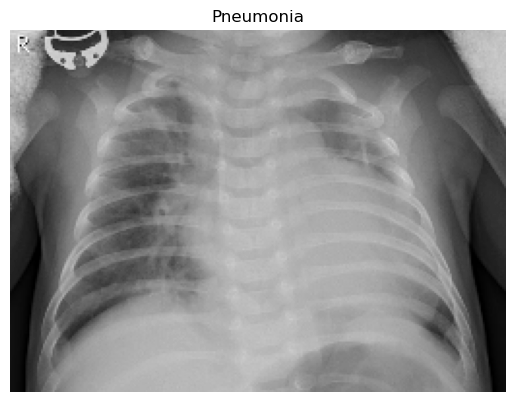

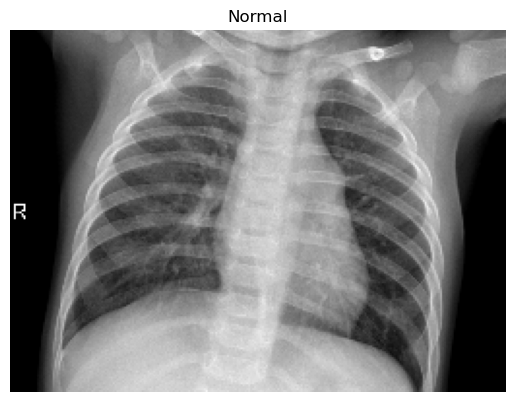

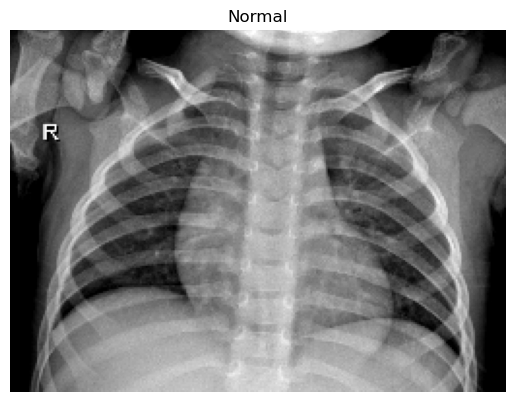

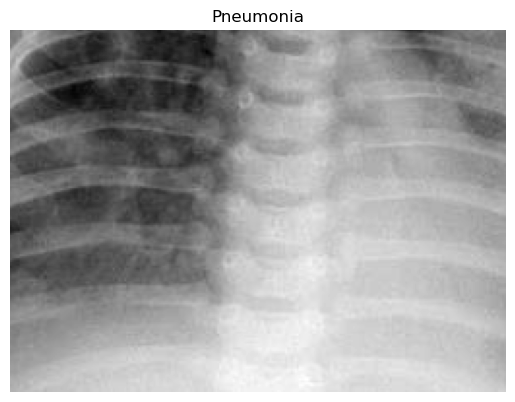

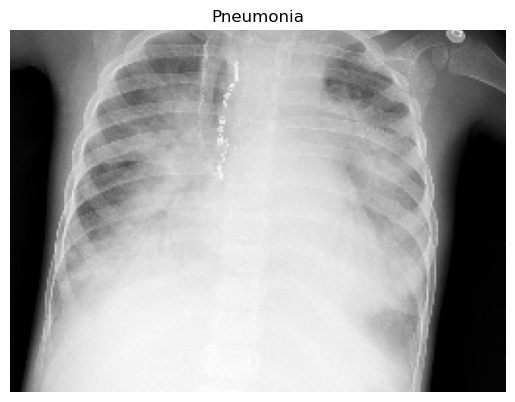

In [81]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Take the first batch from the dataset
for images, labels in train_ds_scaled.take(5):
    # Select the first image and label from the batch
    image = images[0]
    label = labels[0]
    if label == 0:
        label = 'Normal'
    else:
        label = 'Pneumonia'
    
    fig, ax = plt.subplots()
    ax.axis('off')
    ax.imshow(image,cmap='gray')
    ax.set_title(label)
    plt.show()

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomZoom
from code.data_loader import get_datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import Recall

import pandas as pd
from keras.models import load_model

import random
random.seed(42)
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt

import os
# This autoreloads when importing modules or classes


In [ ]:
# After
# Training: 3418 to 1266, ratio: 73-27
# Validation: 428 to 159, ratio: 73-27
# Testing: 427 to 159, ratio: 73-27
# Train-Val-Test ratio total: 4684-587-585  percent: 80-10-10